In [55]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

# Load data
train = pd.read_csv("train_volume_vix.csv", parse_dates=["date"])
test = pd.read_csv("test_volume_vix.csv", parse_dates=["date"])

# Drop missing values just in case
train = train.dropna(subset=["vix_close", "target_volume"])
test = test.dropna(subset=["vix_close", "target_volume"])

In [56]:
# add time features to capture seasonality and trends

train["year"] = train["date"].dt.year
train["month"] = train["date"].dt.month

test["year"] = test["date"].dt.year
test["month"] = test["date"].dt.month


In [57]:
# Log-transform target and input to reduce scale effects
X_train = train[["vix_close", "year", "month"]]
y_train = np.log(train["target_volume"])


X_test = test[["vix_close", "year", "month"]]
y_test = np.log(test["target_volume"])

In [58]:
model = RandomForestRegressor(n_estimators=200, max_depth=25, min_samples_split=5, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(max_depth=25, min_samples_split=5, n_estimators=200,
                      random_state=42)

In [59]:
# Predictions
y_pred = model.predict(X_test)

# Metrics (log scale)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2  = r2_score(y_test, y_pred)
print(f"MSE (log): {mse:.4f}  MAE (log): {mae:.4f}  R² (log): {r2:.3f}")

# Original scale
actual = np.exp(y_test)
pred   = np.exp(y_pred)
mape = (np.abs(pred - actual) / actual).mean() * 100
print(f"MAPE (original scale): {mape:.2f}%")


MSE (log): 0.0375  MAE (log): 0.1288  R² (log): -0.370
MAPE (original scale): 11.80%


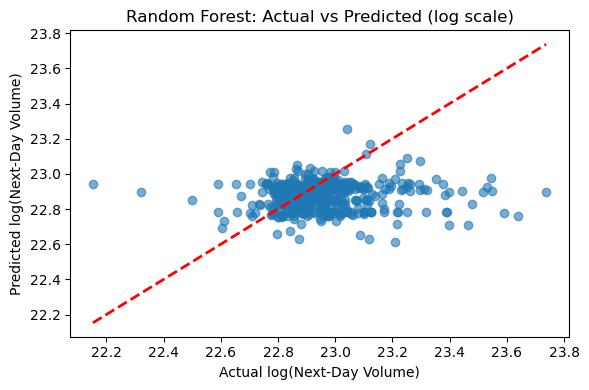

In [60]:
# Actual vs Predicted (log scale)
plt.figure(figsize=(6,4))
plt.scatter(y_test, y_pred, alpha=0.6)
lo, hi = min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())
plt.plot([lo, hi], [lo, hi], 'r--', lw=2)
plt.xlabel("Actual log(Next-Day Volume)")
plt.ylabel("Predicted log(Next-Day Volume)")
plt.title("Random Forest: Actual vs Predicted (log scale)")
plt.tight_layout(); plt.show()


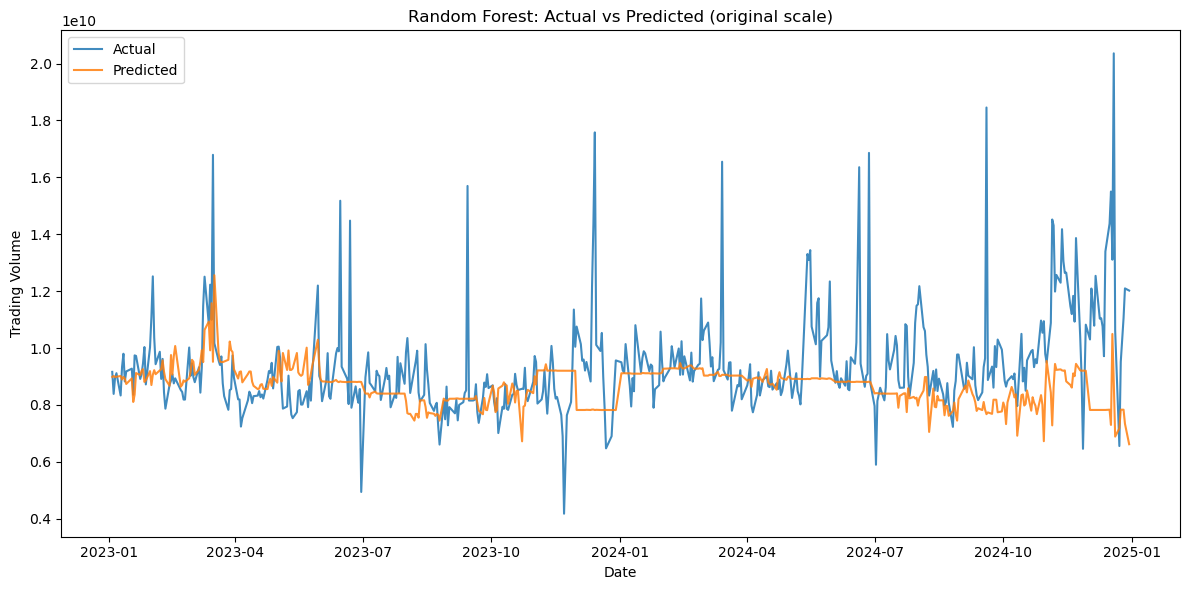

In [61]:

# Time series (original scale)
plot_df = test.copy()
plot_df["actual_volume"] = actual
plot_df["predicted_volume"] = pred

plt.figure(figsize=(12,6))
plt.plot(plot_df["date"], plot_df["actual_volume"], label="Actual", alpha=0.85)
plt.plot(plot_df["date"], plot_df["predicted_volume"], label="Predicted", alpha=0.85)
plt.xlabel("Date"); plt.ylabel("Trading Volume")
plt.title("Random Forest: Actual vs Predicted (original scale)")
plt.legend(); plt.tight_layout(); plt.show()


vix_close    0.518146
year         0.400953
month        0.080901
dtype: float64


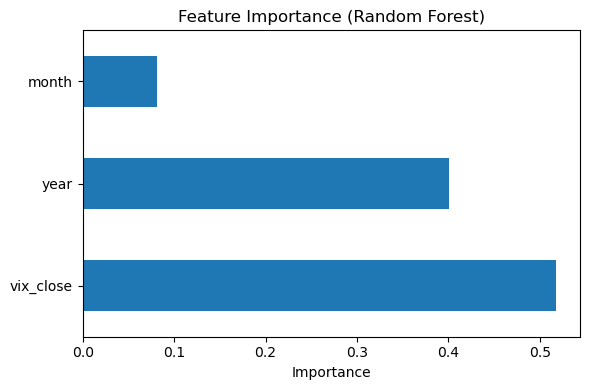

In [62]:
importances = pd.Series(model.feature_importances_, index=X_train.columns)
importances = importances.sort_values(ascending=False)
print(importances)

plt.figure(figsize=(6,4))
importances.plot(kind="barh")
plt.title("Feature Importance (Random Forest)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()
